# Introduction
This post applies accessibility analysis for comparing two types of social amenities: playgrounds / green spaces and alcohol vendors - a wider scope than the cheeky alliterative title would suggest. This post just runs the analysis for Wellington. A follow up post will compare Auckland and Wellington. 

Since we're focusing on a single city, the aim of the post is to establish the following:
- The data sources: availability and credibility
- Getting and processing the data
- Setting up metrics and visualisations for the comparative analysis

# Get alcohol vendor data fromOSM
This section is somewhat techincal. The specifics are not necessary to understand the analysis. 

In [58]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.data_processing as dp
import utils.accessibility_analysis as aa
import geopandas
import numpy as np
import seaborn as sns
import folium

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
#%matplotlib inline

import importlib
importlib.reload(aa)
importlib.reload(dp)

<module 'utils.data_processing' from '/home/shrividya/Documents/playgrounds-pubs/utils/data_processing.py'>

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

![](assets/wellington-city-bounding-box.png)


In [5]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

## Create Query
The following section creates a query to get fuel station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity). For example, we can easily get data for cafes and restaurants by adding these to the tags list.  

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
- Data Primitives: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. 
- Nodes: Single point with explicit [lat, lon] coordinates. Root primitive
- Ways: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 
- Relations: Represent the relationship of existing nodes and ways
- Tags: Metadata stored as key-value pairs. 

The main primitives used in this report are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for fuel station nodes. More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

## Getting data from Overpass 
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. 

Given that pubs, alcohol shops and bars can be described as both nodes and ways, we need two queries to extract the data. Following the data extraction we have to (1) process ways as polygons reduce to POIs, (2) label nodes as POIs, and (3) join the two datasets together. 

There is a reasonable probability that we have duplicates - where the same place has been annotated as both a way and a node. For the first pass of the analysis, I'm going to assume that these are a minority. De-duplication will be a part of the more polished analysis. 

In [6]:
# What types of entitities do we want to get? 
tags = ['alcohol', 'pub', 'bar', 'beverages', 'biergarten', 'wine', 'supermarket']
entities = ['shop', 'amenity', 'building']

### Get nodes

In [52]:
# Generate the query string for nodes
objects = ['node'] # like way, node, relation
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store nodes as df
osmdf_nodes = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_nodes = (osmdf_nodes[['id', 'lat', 'lon', 'name', 'amenity', 'type']]
                 .sort_values(['lat', 'lon'])
                 .reset_index()
                 .drop(columns='index')
                 .fillna('No Name'))
print(alcohol_nodes.shape)
alcohol_nodes.head(5)

(138, 6)


,id,lat,lon,name,amenity,type
0,4522166458,-41.328972,174.811298,Cook Strait Bar,bar,node
1,623879839,-41.325184,174.820872,The Strathmore Local,pub,node
2,625080280,-41.319506,174.794358,Bay 66,pub,node
3,4362160389,-41.318292,174.794757,No Name,No Name,node
4,627273501,-41.318117,174.794450,Kilbirnie Tavern,pub,node


### Get and process ways
Processing ways for accessibility analysis means we need to find a way of reducing polygons to points. 

In [54]:
# Generate the query string for ways
objects = ['way'] # like way, node, relation
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store ways as df
osmdf_ways = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_ways = osmdf_ways[['id', 'lat', 'lon', 'name', 'amenity', 'type', 'nodes']]
print(alcohol_ways.shape)
alcohol_ways.head(5)

(289, 7)


,id,lat,lon,name,amenity,type,nodes
0,26509771,NaN,NaN,New World,NaN,way,"[290565312, 290565316, 2990208452, 2990208451,..."
1,49396700,NaN,NaN,Countdown,NaN,way,"[627273504, 4699896634, 627273505, 4199712656,..."
2,62153738,NaN,NaN,Mac's Brewery,pub,way,"[775428527, 775428528, 775428657, 775428658, 2..."
3,62154227,NaN,NaN,Countdown Johnsonville,NaN,way,"[1439843310, 1439843337, 1439843339, 143984333..."
4,133129214,NaN,NaN,Thistle Inn,bar,way,"[1464807182, 1464807184, 1464807179, 146480718..."


In [59]:
# Cleaning up way data 
osmdf_ways_clean = dp.extend_ways_to_node_view(alcohol_ways)
osmdf_ways_clean.fillna('No Name', inplace=True)
alcohol_ways.fillna('No Name', inplace=True)

# Run centroid calculation
alcohol_ways_nodes = (osmdf_ways_clean
                      .merge(alcohol_ways[['id', 'amenity', 'name']]
                             .drop_duplicates(), left_on='way_id', right_on='id')
                      .groupby(['way_id', 'name', 'amenity', 'type'])
                      .agg({'lat': 'mean', 'lon': 'mean' })
                      .reset_index()
                      .rename(columns={'way_id': 'id'}))

# Join polygon centroids and node data for a comprehensive set
alcohol_pois = pd.concat([alcohol_nodes, alcohol_ways_nodes])

In [60]:
map_alcohol = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in alcohol_pois.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_alcohol)
#    folium.Popup(each[1]['name']).add_to(map_alcohol)

map_alcohol.save('map_alcohol.html')
map_alcohol


# Quality of alcohol vendor data
The paper by [Bright et al.](https://www.sciencedirect.com/science/article/pii/S1353829217305804) gives an excellent overview of why alcohol research is important - in terms of spatial availability. It also evaluates the use of alcohol vendor data from Open Street Map. Though the analysis was carried out for the UK, we can extrapolate the general principle that data is unlikely to be complete for NZ. Possibly even more so since we're a smaller country, and OSM has a much greater set of contributers in the UK - owing to the fact that OSM began in the UK. 

## Alternatives: NZLII
An alternative soure of alcohol data to OSM is the [New Zealand Legal Information Institute's](http://www.nzlii.org/) database on alcohol licence decsions. The site for Wellington is [here](http://www.nzlii.org/nz/cases/NZDLCWN/). The licence [requests for the current year](http://www.nzlii.org/nz/cases/NZDLCWN/2018/) can be examined in detail. Unfortunately, the decisions are uploaded as pdfs. 

While text can be extracted from the pdfs, the retreival of information requires a few components:
- Web scraping with bs4 to systematically download all the pdfs of decisions for a given year.
- Loading the pdf as an object with PyPDF2.
- Searching the text with well-constructed regular expressions to get the name of venue and the decision.
- Matching the licence venues to a geolocation. Adding in missing venues to OSM.

I think this can actually be done. I'd need some help in crafting the regular expression and, the project will take some time - which menas I need to decide how and why it would be worth scraping the database.

## Alternatives: Healthspace
A Google search led me to this page which [aggregates alcohol-related data and research for NZ](https://www.alcohol.org.nz/resources-research/facts-and-statistics/where-to-find-other-alcohol-statistics). From there, I navigated to Healthspace, which makes available [Statistical Area 2 level alcohol licence data](http://healthspace.ac.nz/resource/view?resourceId=37). The data download portal [here](http://healthspace.ac.nz/explorer/resources/listbytheme) as xlsx tables. The interface is clunky unfortunately and the latest data is from 2016. Nonetheless, if we want SA2 or larger area unit aggregates, this data is great. I will make a request to see if they have the licence information available at the individual outlet level. 

# Get parks data
We have two sources of park data available from WCC:
- [WCC parks and reserves](https://data-wcc.opendata.arcgis.com/datasets/581d698fd2614a4c8f860c8007e4e104_0)
- [WCC playgrounds](https://data-wcc.opendata.arcgis.com/datasets/c3b0ae6ee9d44a7786b0990e6ea39e5d_0)

As of 18 Sept, I've only done the analysis on the polygon data of parks and reserves. Repeating the analysis with playgrounds as the focus will be on how family friendly the region is. 


In [8]:
wcc_parks = geopandas.read_file('zip://./data/WCC_Parks_and_Reserves.zip')
wcc_parks['centroid'] = wcc_parks.centroid

In [9]:
wcc_parks[['name_', 'address', 'geometry']].head()

,name_,address,geometry
0,Ex Wellington Bowling Club Land,Tanera Crescent,"POLYGON ((174.765237429376 -41.300402529001, 1..."
1,Waimapihi Reserve,Holloway Road,"POLYGON ((174.755229696891 -41.2989941468547, ..."
2,Newlands Plunket/Kenmore Street Play Area,"108 Kenmore Street, Horokiwi Road","POLYGON ((174.825350752449 -41.223283485097, 1..."
3,"Railway Station Reserve, Bunny Street",Bunny Street,"POLYGON ((174.780368233065 -41.2795407305749, ..."
4,Seatoun Wharf and Boatsheds,Marine Parade,"(POLYGON ((174.829013038144 -41.3179656818365,..."


## Sample points from a polygon

In [10]:
# Sampling parameters
lon_corr = 0.1
lat_corr = 0.0
lon_sd = 0.1
lat_sd = 0.1
sample_size = 2000

# Generate random sample data
df = pd.DataFrame({'lon': np.random.normal(mean_lon + lon_corr, lon_sd, size=(sample_size)),
                   'lat': np.random.normal(mean_lat + lat_corr, lat_sd, size=(sample_size))})

# create Geometry series with lat / longitudes
points = dp.lat_lon_to_geopandas(df)

# Find intersecting points with park polygons
intersecting_points = []

for i  in range(len(wcc_parks)):
    x = points[points.within(wcc_parks['geometry'].ix[i])]
    if len(x) > 0:
        intersecting_points.append(x)
        
intersecting_points = pd.concat(intersecting_points)

# Create lat, lon POIS dataframe
park_set_pois= dp.geopandas_to_lat_lon(intersecting_points, 'geometry')
park_pois_df = dp.lat_lon_to_geopandas(park_set_pois)

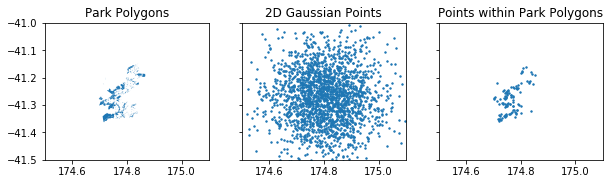

In [11]:
# Plot transformation
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(10, 4))
ax1.set_title('Park Polygons')
wcc_parks.plot(ax=ax1)
ax2.set_title('2D Gaussian Points')
points.plot(ax=ax2, markersize=2)
ax3.set_title('Points within Park Polygons')
park_pois_df.plot(ax=ax3, markersize=2)
plt.subplots_adjust(hspace=-0.2)

# Limits
plt.xlim(174.5, 175.1);
plt.ylim(-41.5, -41.0);

In [17]:
map_parks = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in park_set_pois.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_parks)
#    folium.Popup(each[1]['name']).add_to(map_alcohol)

map_parks
map_parks.save('map_parks.html')

# Accessibility analysis

## Calculating accessibility
Here, we consider accessibility as the driving distance in meters from each grid point (also referred to as nodes) to the nearest POIS: a fuel station. To do a visual acessibility analysis we need to: 
- Break up the map into grid of points (I) 
- Calculate the distance from each point to the nth nearest POIS (II) 
- Visualise distance as a heatmap (III)

All the above steps are carried out by the Python package Pandana. Of the above steps, I has a few sub-steps. These are: 
- Download OSM data within the specified bounding box 
- Convert map to point grid. Remember, this is easy since all OSM streets and roads are *ways* which are simply a collection of nodes / points. 
- Store points data in a convenient data structure: a Pandas dataframe 
- Filter out poorly connected points

In [13]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [61]:
# Generate accessibility network
network = aa.get_pandana_network(osm_bbox, impedance=distance)
alco_accessibility = aa.get_accessibility(network, alcohol_pois, distance=distance, num_pois=num_pois)
park_accessibility = aa.get_accessibility(network, park_set_pois, distance=distance, num_pois=num_pois)

data/network_-41.38_174.57_-41.1527_174.84.h5


## Accessibility to alcohol

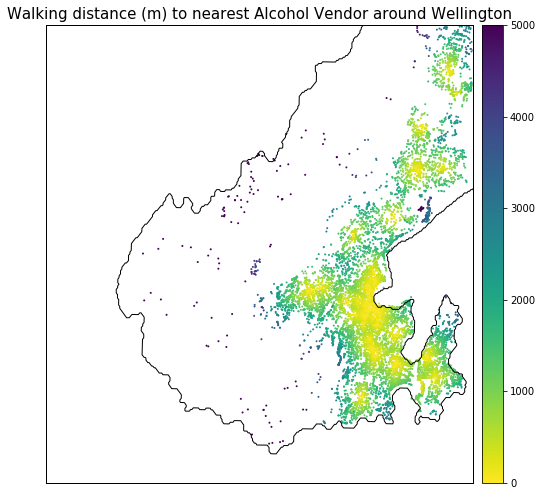

In [64]:
# Plot driving accessibility alcohol vendors
aa.plot_accessibility(network, alco_accessibility[n], osm_bbox, 
                      amenity_type='Alcohol Vendor', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

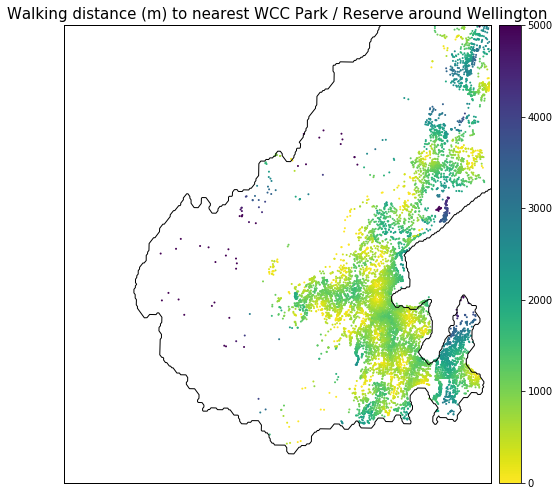

In [65]:
# Plot driving accessibility for Parks
aa.plot_accessibility(network, park_accessibility[n], osm_bbox,
                      amenity_type='WCC Park / Reserve', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

## Differential accessbility: playgrounds vs. alcohol

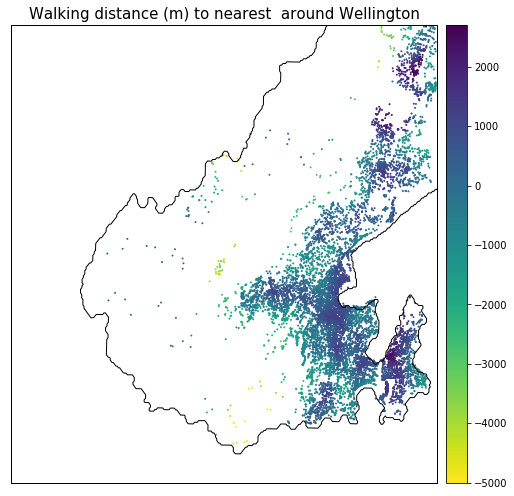

In [66]:
# Plotting parameters
diff_kwargs = plot_kwargs.copy()
# diff_kwargs['cmap'] = 'spectral_r'
bmap_kwargs={'epsg':'2193','resolution':'f'}
cbar_kwargs = {'location': 'right'}

# Plot differential coverage


diff_accessibility = park_accessibility[1] - alco_accessibility[1]
bmap = aa.plot_accessibility(network, diff_accessibility, osm_bbox, 
                             amenity_type="",
                             place_name='Wellington', 
                             fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)

In [67]:
orig_nodes = network.nodes_df 
def filtered_accessibility_network(pandana_network, filtered_accessibility):

    network_nodes = pandana_network.nodes_df.reset_index()
    new_network_nodes = []
    for node in filtered_accessibility.reset_index()['id'].tolist():
        val = network_nodes[network_nodes['id'] == node]
        new_network_nodes.append(val)
    
    new_network_nodes = pd.concat(new_network_nodes).set_index('id')
    pandana_network.nodes_df = new_network_nodes
    return pandana_network, filtered_accessibility


In [68]:
# Get filtered network for plotting
network_access_1000, access_1000 = filtered_accessibility_network(network, 
                                                                  diff_accessibility[diff_accessibility > 1000])

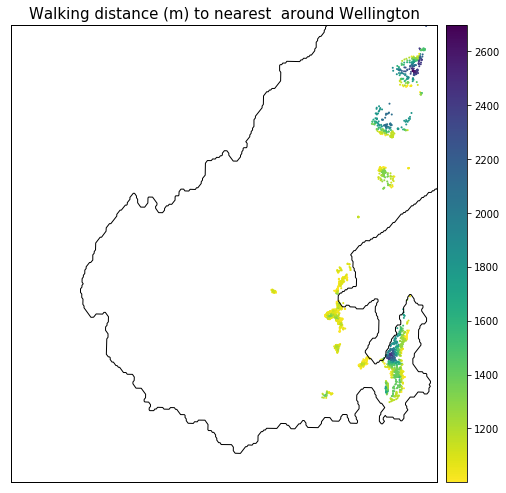

In [69]:
bmap = aa.plot_accessibility(network_access_1000, access_1000, osm_bbox, 
                             amenity_type="",
                             place_name='Wellington', 
                             fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)

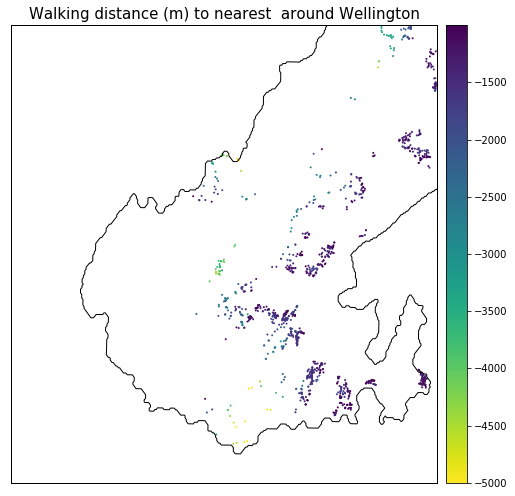

In [70]:
# Get filtered network for plotting
network.nodes_df = orig_nodes
network_access_neg_1000, access_neg_1000 = filtered_accessibility_network(network, 
                                                                          diff_accessibility[diff_accessibility < -1000])

bmap = aa.plot_accessibility(network_access_neg_1000, access_neg_1000, osm_bbox, 
                             amenity_type="",
                             place_name='Wellington', 
                             fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)

## Accessibility statistics

In [71]:
# Put accessibility data together
nearest_park = park_accessibility[1].reset_index(name='distance')
nearest_alco = alco_accessibility[1].reset_index(name='distance')
nearest_park['type'] = 'Park / Reserve'
nearest_alco['type'] = 'Alcohol'

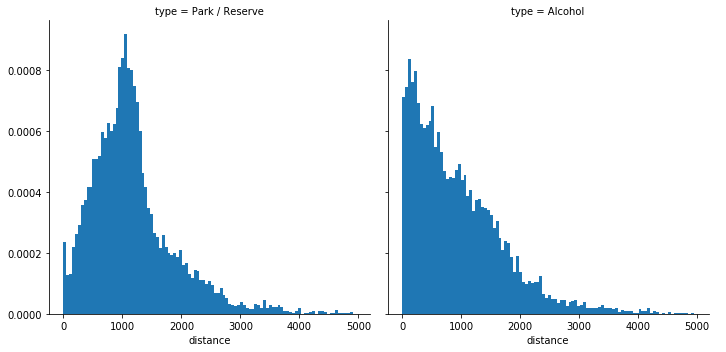

In [72]:
# Plot Z and BP accessibility together
nearest_p = pd.concat([nearest_park, nearest_alco])
nearest_p = nearest_p.query('distance < 5000')
g = sns.FacetGrid(col='type', data=nearest_p, size=5)
g.map(plt.hist, 'distance', normed=True, bins=100)
#g.map(aa.vertical_average_lines, 'distance')
g.add_legend()